In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h2 style="text-align: center">Getting Started with AutoSxS: Evaluate multiple LLM responses in Vertex AI pipeline
</h2>


---



The Vertex AI Model Garden enables you to test, customize, and deploy instances of Google’s large language models (LLM) as well as Open LLMs like Meta, Mistral, Stable Diffusion, Claude, etc.  You can leverage the capabilities of Open LLMs in your applications.
This lab demonstrates how to use Vertex AI automatic side-by-side (AutoSxS) to evaluate the performance between 2 generative AI models using Vertex AI pipelines
AutoSxS is a model-assisted evaluation tool that helps you compare two large language models (LLMs) side by side. As part of AutoSxS's preview release, we only support comparing models for summarization and question answering tasks. We will support more tasks and customization in the future.
Learn more about Vertex AI AutoSxS Model Evaluation.




**Objectives:**

In this tutorial, you learn how to use Vertex AI Pipelines and google_cloud_pipeline_components to evaluate the performance between two LLM models:
This tutorial uses the following Google Cloud ML services and resources:
Cloud Storage
Vertex AI Pipelines
Vertex AI Batch Prediction
The steps performed include:
Fetch the dataset from the public source.
Preprocess the data locally and save test data in Cloud Storage.
Create and run a Vertex AI AutoSxS Pipeline that generates the judgments and evaluates the two candidate models using the generated judgments.
Print the judgments and evaluation metrics.
Clean up the resources created in this notebook.


✅ Introduce Vertex Model Garden

✅ Introduce Vertex AI Pipelines

✅ Compare Mistral & Llama model outputs



## Install Necessary Dependencies

Installation:

Install the following packages required to execute this notebook.

In [ ]:
! pip3 install --upgrade --quiet \
    google-cloud-aiplatform \
    google-cloud-pipeline-components==2.13.0 \
    gcsfs \
    datasets \
    fsspec==2023.9.2

## Authenticate with Google Account and set up the project ID

In [ ]:
# RUN ONLY IN A COLAB ENV

# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# Get the default cloud project id.
PROJECT_ID = "Enter your project>"  # e.g.: "qwiklabs-gcp-04-5bb7efa7ee"

# Get the default region for launching jobs.
REGION = "<Enter Region>" #"us-central1"

Gets the default BUCKET_URI and SERVICE_ACCOUNT if they were not specified by the user.


In [ ]:

# Gets the default BUCKET_URI and SERVICE_ACCOUNT if they were not specified by the user.

SERVICE_ACCOUNT = None
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
print("Using this default Service Account:", SERVICE_ACCOUNT)


Using this default Service Account: 48694999037-compute@developer.gserviceaccount.com


**Set your project ID**

If you don't know your project ID, try the following:


Run gcloud config list.

Run gcloud projects list.

See the support page: Locate the project ID


In [ ]:
!gcloud config set project $PROJECT_ID # e.g. qwiklabs-gcp-04-5bb7efa7ee

Updated property [core/project].


## Create a Cloud Storage Bucket

The provided code snippet is a Python function that generates a random Universally Unique Identifier (UUID) of a specified length. Here's how the code works:



In [ ]:
import random
import string


def generate_uuid(length: int = 8) -> str:
    """Generate a uuid of a specified length (default=8)."""
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

 Create a bucket

In [ ]:
BUCKET_URI = "gs://" + PROJECT_ID + "-aip-" + UUID
print("Creating bucket: ", BUCKET_URI)
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

In [ ]:
# Provision permissions to the SERVICE_ACCOUNT with the GCS bucket
BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME


## Install the Necessary Libraries

In [ ]:
import os
import pandas as pd
from google.cloud import aiplatform
from google_cloud_pipeline_components.preview import model_evaluation
from kfp import compiler
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models

## Initialize Vertex AI SDK

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## XSum Dataset Exploration: Selecting and Evaluating 10 Samples for the Evaluation D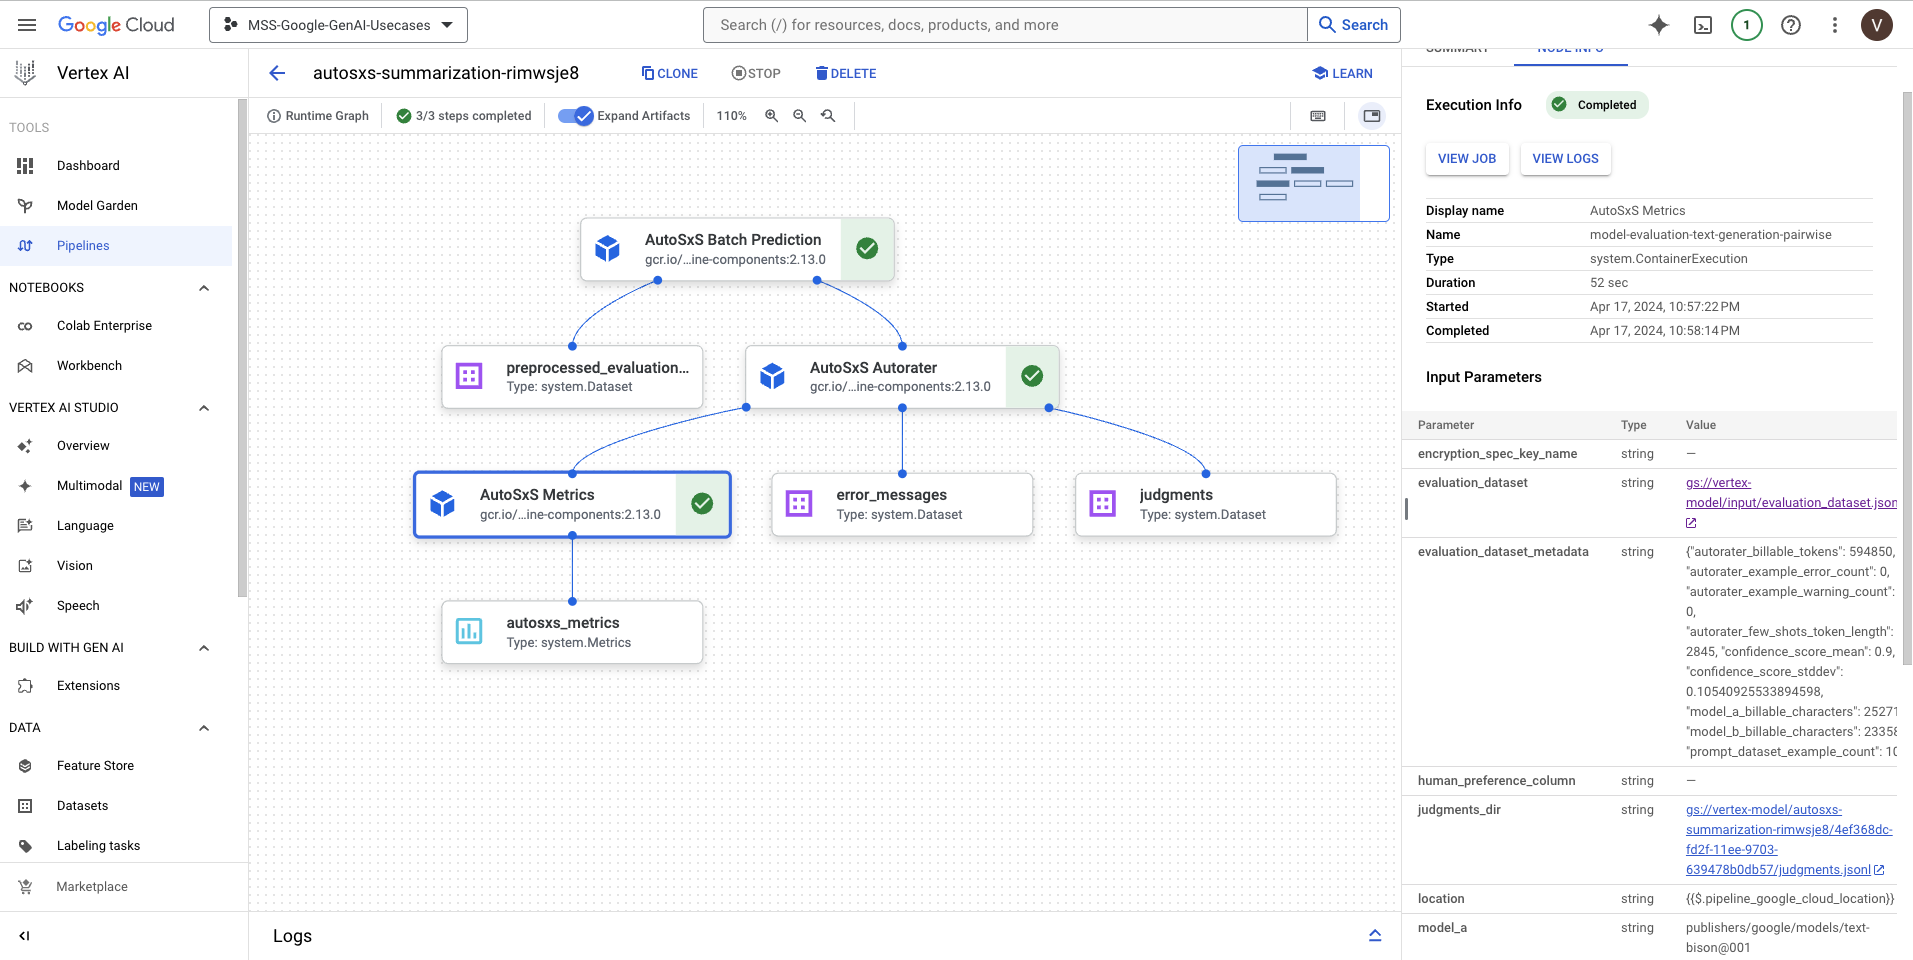

## Uploading the Dataset with Pre generated Mistral and Llama predictions

Get the evaluation file

In [ ]:
examples=pd.read_csv("vertex_ai_auto_sxs_gc.csv")

In [ ]:
examples

,Unnamed: 0,content,gemini,claude
0,1,"Figures show that for those aged 65, men can e...",Life expectancy in England has reached its hig...,Life expectancy among older age groups in Engl...
1,2,Media playback is not supported on this device...,"In a closely contested rugby match, Wales edge...",Wales edged out Argentina 24-20 in a tight mat...
2,3,But the Premier League club say they want Alla...,Sunderland wants Sam Allardyce to remain as th...,The Sunderland football club has released a st...
3,4,If he does become the next Premier League mana...,Tim Sherwood should not be sacked as Aston Vil...,The author strongly supports Tim Sherwood succ...
4,5,An internal prison report seen by the BBC says...,Two prisoners at Wayland Prison attempted to e...,An internal report states that an inmate at HM...
5,6,He is approaching the end of his 10th year in ...,"Roddy Smith, CEO of Cricket Scotland, is stepp...",Roddy Smith is stepping down after nearly 10 y...
6,7,Transport Minister Edwina Hart said she also w...,Welsh Transport Minister Edwina Hart introduce...,Transport Minister Edwina Hart wants to introd...
7,8,Operation Equinox is investigating claims of s...,Operation Equinox is investigating claims of s...,Operation Equinox investigates abuse claims ma...
8,9,"The 130m-tall (420ft) Bulford Kiwi, on Bulford...",The 130m Bulford Kiwi chalk carving created by...,"The Bulford Kiwi, a 130m-tall chalk carving cr..."


## Saving and Uploading Evaluation Dataset to Cloud Storage

In [ ]:
examples.to_json("evaluation_dataset.json", orient="records", lines=True)
! gsutil cp evaluation_dataset.json $BUCKET_URI/input/evaluation_dataset.json
DATASET = f"{BUCKET_URI}/input/evaluation_dataset.json"

Copying file://evaluation_dataset.json [Content-Type=application/json]...
/ [1 files][ 33.3 KiB/ 33.3 KiB]                                                
Operation completed over 1 objects/33.3 KiB.                                     


## Compiling AutoSXS Pipeline from YAML Template

In [ ]:
template_uri = "pipeline.yaml"
compiler.Compiler().compile(
    pipeline_func=model_evaluation.autosxs_pipeline,
    package_path=template_uri,
)

## Setting Up AutoSXS Summarization Task

In [ ]:
display_name = f"autosxs-summarization-{generate_uuid()}"
prompt_column = "content"
response_column_a="mistral"
response_column_b = "llama"
DATASET = f"{BUCKET_URI}/input/evaluation_dataset.json"
parameters = {
    "evaluation_dataset": DATASET,
    "id_columns": [prompt_column],
    "autorater_prompt_parameters": {
        "inference_context": {"column": prompt_column},
        "inference_instruction": {"template": "{{ default_instruction }}"},
    },
    "task": "summarization",
    "response_column_a":response_column_a,
    "response_column_b": response_column_b,
}

## Running AutoSXS Summarization Pipeline

In [ ]:
job = aiplatform.PipelineJob(
    job_id=display_name,
    display_name=display_name,
    pipeline_root=os.path.join(BUCKET_URI, display_name),
    template_path=template_uri,
    parameter_values=parameters,
    enable_caching=False,
)
job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/48694999037/locations/us-central1/pipelineJobs/autosxs-summarization-6piuj8aa
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/48694999037/locations/us-central1/pipelineJobs/autosxs-summarization-6piuj8aa')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/autosxs-summarization-6piuj8aa?project=48694999037
PipelineJob projects/48694999037/locations/us-central1/pipelineJobs/autosxs-summarization-6piuj8aa current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/48694999037/locations/us-central1/pipelineJobs/autosxs-summarization-6piuj8aa current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/48694999037/locations/us-central1/pipelineJobs/autosxs-summarization-6piuj8aa current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/48694999037/locations/us-central1/pipelineJobs/autosxs-s

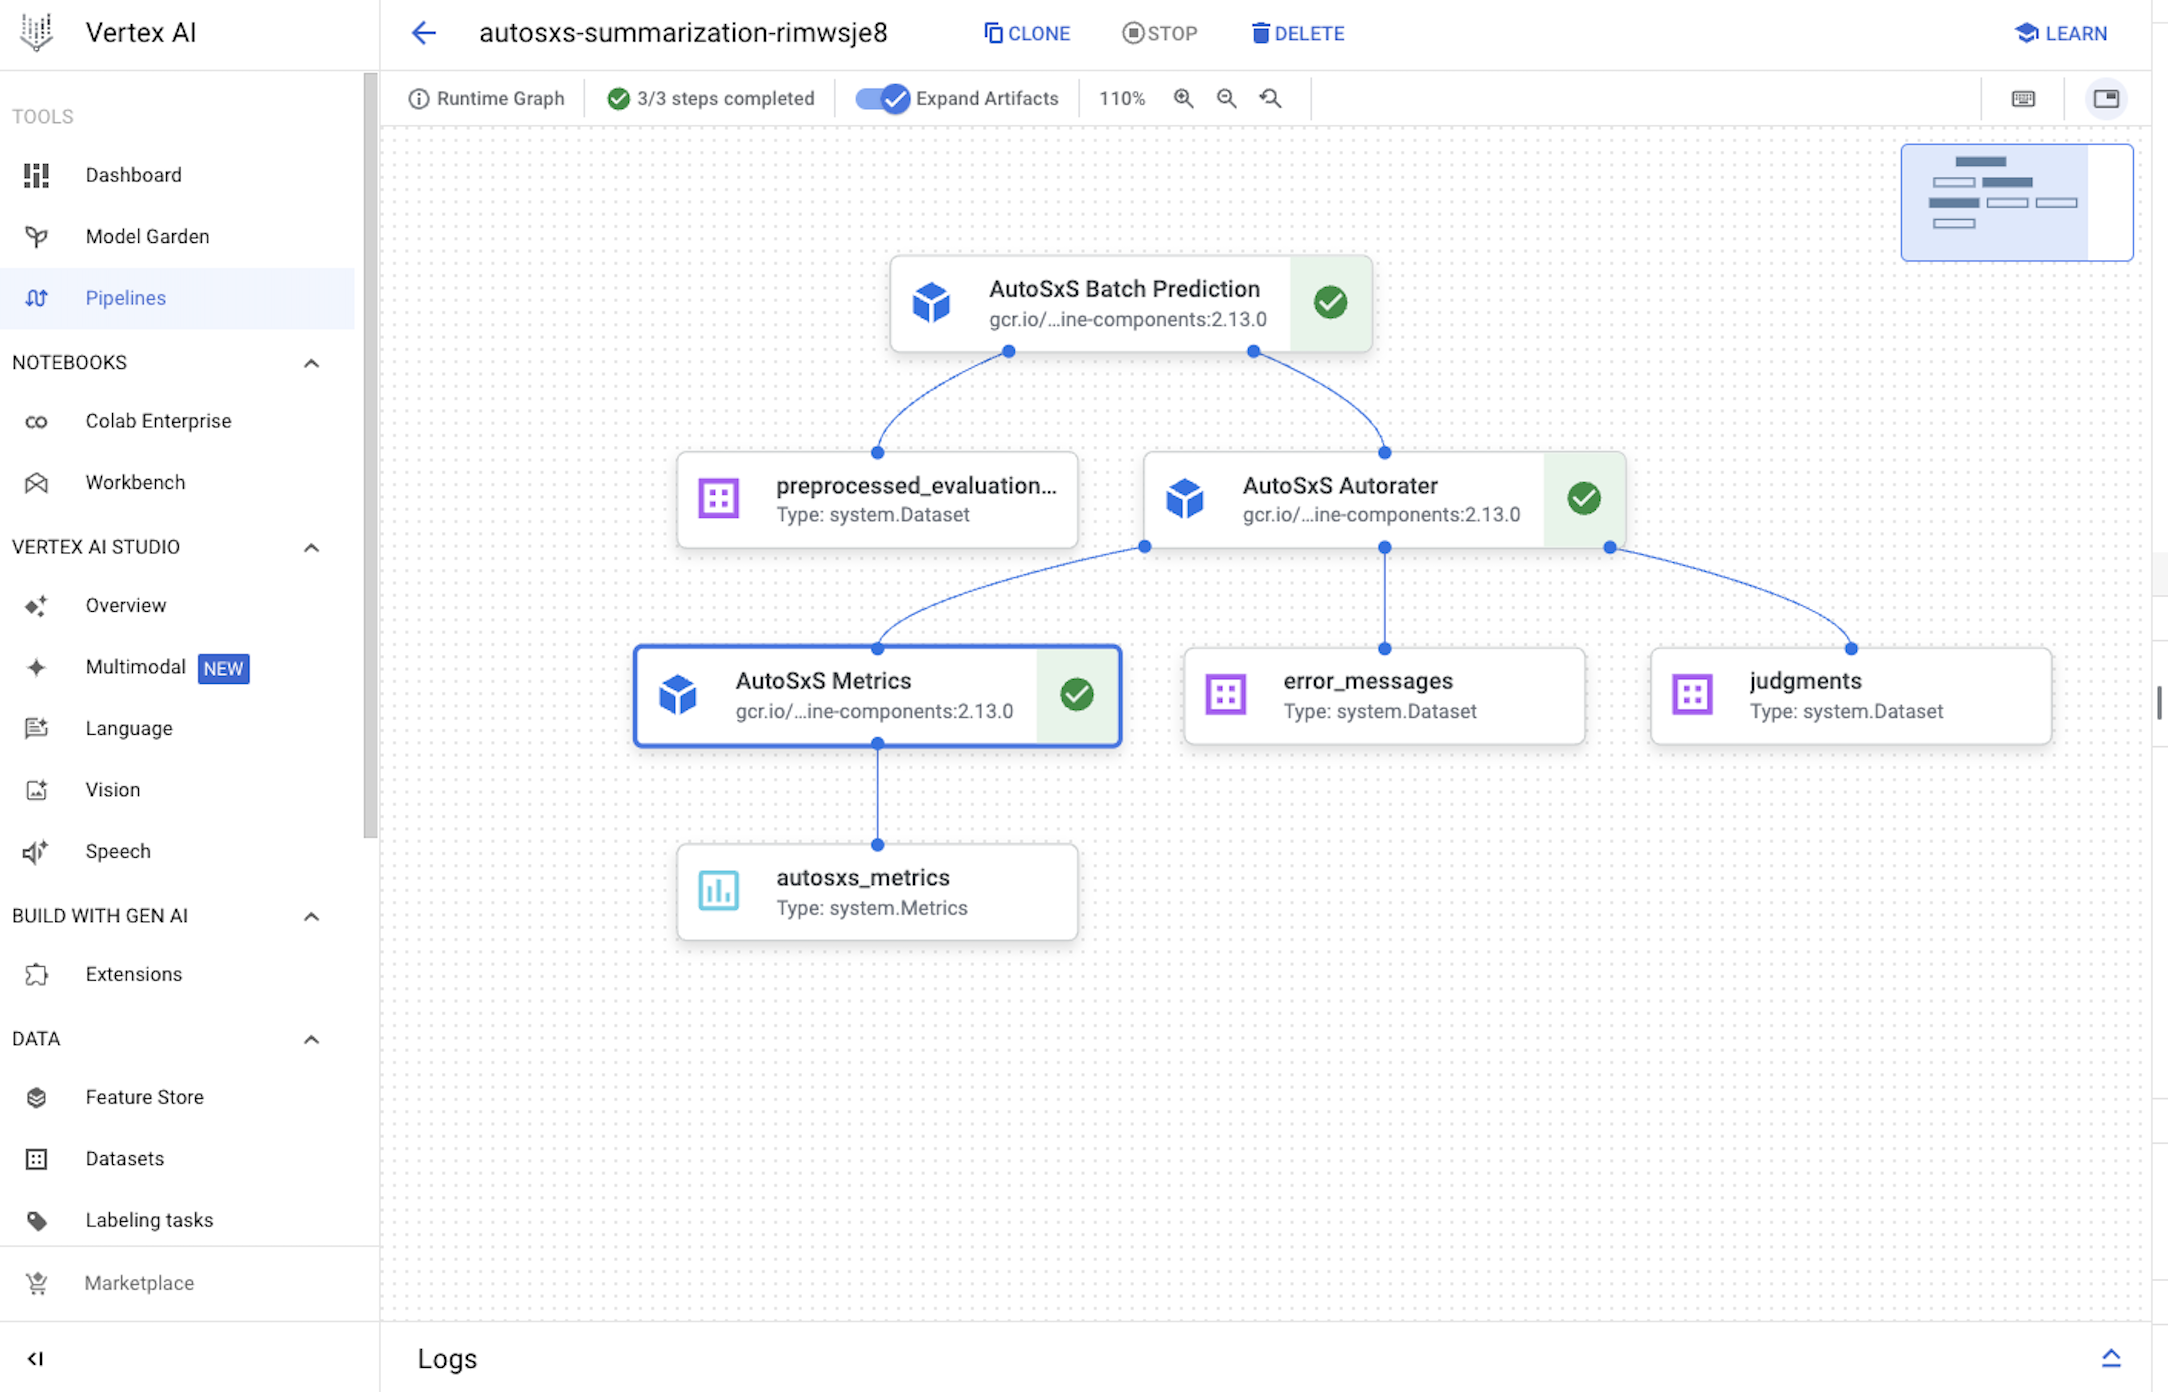

## Retrieving Online Evaluation Judgments

In [ ]:
for details in job.task_details:
    if details.task_name == "online-evaluation-pairwise":
        break

# Judgments
judgments_uri = details.outputs["judgments"].artifacts[0].uri
judgments_df = pd.read_json(judgments_uri, lines=True)
judgments_df.rename(columns={'response_a': response_column_a + ' (A)'}, inplace=True)
judgments_df.rename(columns={'response_b': response_column_b + ' (B)'}, inplace=True)
judgments_df.head()


,content,inference_instruction,inference_context,response_a,response_b,choice,explanation,confidence
0,"Figures show that for those aged 65, men can e...",Summarize INPUT in a few sentences. Rely stric...,"Figures show that for those aged 65, men can e...",Life expectancy in England has reached its hig...,Life expectancy among older age groups in Engl...,B,Response (B) follows the instruction to rely s...,0.9
1,Media playback is not supported on this device...,Summarize INPUT in a few sentences. Rely stric...,Media playback is not supported on this device...,"In a closely contested rugby match, Wales edge...",Wales edged out Argentina 24-20 in a tight mat...,B,Response (B) is better than Response (A) becau...,0.6
2,An internal prison report seen by the BBC says...,Summarize INPUT in a few sentences. Rely stric...,An internal prison report seen by the BBC says...,Two prisoners at Wayland Prison attempted to e...,An internal report states that an inmate at HM...,A,Both responses accurately summarize the events...,0.3
3,Transport Minister Edwina Hart said she also w...,Summarize INPUT in a few sentences. Rely stric...,Transport Minister Edwina Hart said she also w...,Welsh Transport Minister Edwina Hart introduce...,Transport Minister Edwina Hart wants to introd...,B,Both responses provide important details about...,1.0
4,"The 130m-tall (420ft) Bulford Kiwi, on Bulford...",Summarize INPUT in a few sentences. Rely stric...,"The 130m-tall (420ft) Bulford Kiwi, on Bulford...",The 130m Bulford Kiwi chalk carving created by...,"The Bulford Kiwi, a 130m-tall chalk carving cr...",A,Response (A) is more helpful by providing addi...,0.6


## Extracting AutoSXS Text Generation Metrics

In [ ]:
# Metrics
for details in job.task_details:
    if details.task_name == "model-evaluation-text-generation-pairwise":
        break
pd.DataFrame([details.outputs["autosxs_metrics"].artifacts[0].metadata])

## Deleting AutoSXS Pipeline Job and Cleanup

In [ ]:
import os

job.delete()

# Delete Cloud Storage objects that were created
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI

INFO:google.cloud.aiplatform.base:Deleting PipelineJob : projects/793025276323/locations/us-central1/pipelineJobs/autosxs-summarization-lkxd5age
INFO:google.cloud.aiplatform.base:Delete PipelineJob  backing LRO: projects/793025276323/locations/us-central1/operations/1723588414747443200
INFO:google.cloud.aiplatform.base:PipelineJob deleted. . Resource name: projects/793025276323/locations/us-central1/pipelineJobs/autosxs-summarization-lkxd5age
